# Ultrasonic distance sensor analysis

Reusable functions for raw/cleaned histograms, per-trial stats, and expected vs actual distance plots with error bars and best-fit lines. All functions take pandas DataFrames (e.g. from your CSV data).

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import linregress
import numpy as np

In [2]:
def get_stats(df, register=None):
    """
    Compute per-trial summary stats from raw sensor data.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must have columns: trial, register, rdistance, strength, edistance.
    register : int or None
        If given, filter to this register only; otherwise use all rows.
    
    Returns
    -------
    pd.DataFrame with columns: trial, expected_distance, median_distance, mean_distance,
    std_distance, median_error, mean_error, count, mean_strength, median_strength.
    """
    work = df.copy()
    if register is not None:
        work = work[work["register"] == register].copy()
    work["error_mm"] = work["rdistance"] - work["edistance"]
    work["abs_strength"] = work["strength"].abs()
    stats = (
        work.groupby("trial")
        .agg(
            expected_distance=("edistance", "median"),
            median_distance=("rdistance", "median"),
            mean_distance=("rdistance", "mean"),
            std_distance=("rdistance", "std"),
            median_error=("error_mm", "median"),
            mean_error=("error_mm", "mean"),
            count=("rdistance", "size"),
            mean_strength=("abs_strength", "mean"),
            median_strength=("abs_strength", "median"),
        )
        .reset_index()
    )
    return stats


def remove_outliers_per_trial(df, value_col="rdistance", trial_col="trial", n_std=2.0):
    """
    Return a copy of df with rows removed where value_col is more than n_std
    standard deviations from the trial median.
    """
    def keep_inliers(g):
        med = g[value_col].median()
        std = g[value_col].std()
        if std == 0 or pd.isna(std):
            return g
        return g[abs(g[value_col] - med) <= n_std * std]

    return (
        df.groupby(trial_col, group_keys=False)
        .apply(keep_inliers)
        .reset_index(drop=True)
    )

In [3]:
def plot_histogram_raw(df, value_col="rdistance", register=None, bins=30, title=None, ax=None):
    """
    Plot histogram of raw values (e.g. rdistance or error).
    
    Parameters
    ----------
    df : pd.DataFrame with trial, register, rdistance, edistance.
    value_col : str
        Column to histogram (e.g. 'rdistance', or use a precomputed 'error_mm' column).
    register : int or None
        If given, filter to this register before plotting.
    bins, title, ax : optional.
    """
    data = df.copy()
    if register is not None:
        data = data[data["register"] == register]
    if value_col == "error_mm" and "error_mm" not in data.columns:
        data["error_mm"] = data["rdistance"] - data["edistance"]
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(data[value_col].dropna(), bins=bins, edgecolor="black", alpha=0.7)
    ax.set_xlabel(value_col)
    ax.set_ylabel("Count")
    ax.set_title(title or f"Raw {value_col}")
    plt.tight_layout()
    return ax


def plot_histogram_cleaned(df, value_col="rdistance", trial_col="trial", n_std=2.0, register=None, bins=30, title=None, ax=None):
    """
    Plot histogram after removing per-trial outliers.
    """
    data = df.copy()
    if register is not None:
        data = data[data["register"] == register]
    cleaned = remove_outliers_per_trial(data, value_col=value_col, trial_col=trial_col, n_std=n_std)
    if value_col == "error_mm" and "error_mm" not in cleaned.columns:
        cleaned["error_mm"] = cleaned["rdistance"] - cleaned["edistance"]
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(cleaned[value_col].dropna(), bins=bins, edgecolor="black", alpha=0.7, color="green")
    ax.set_xlabel(value_col)
    ax.set_ylabel("Count")
    ax.set_title(title or f"Cleaned {value_col} (n_std={n_std})")
    plt.tight_layout()
    return ax

In [4]:
def plot_expected_vs_actual(
    df_or_stats,
    x_col="expected_distance",
    y_col="median_distance",
    y_err_col="std_distance",
    add_best_fit=True,
    figsize=(7, 5),
    title="Expected vs reported distance",
    ax=None,
):
    """
    Plot expected distance (x) vs actual median/mean distance (y) with error bars and optional best-fit line.
    
    Parameters
    ----------
    df_or_stats : pd.DataFrame
        Either raw sensor df (will call get_stats with register=0) or a stats DataFrame
        from get_stats() with columns expected_distance, median_distance, mean_distance, std_distance.
    x_col, y_col : str
        Column names for x and y (e.g. expected_distance, median_distance or mean_distance).
    y_err_col : str or None
        Column for error bar half-lengths (e.g. std_distance). Set None to skip error bars.
    add_best_fit : bool
        If True, plot linear regression and report slope, intercept, R².
    """
    if "expected_distance" in df_or_stats.columns and "median_distance" in df_or_stats.columns:
        stats = df_or_stats
    else:
        stats = get_stats(df_or_stats, register=0)
    
    stats = stats.dropna(subset=[x_col, y_col])
    x = stats[x_col].values
    y = stats[y_col].values
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    if y_err_col and y_err_col in stats.columns:
        err = stats[y_err_col].fillna(0).values
        ax.errorbar(x, y, yerr=err, fmt="o", capsize=4, capthick=1.5, label="Data")
    else:
        ax.scatter(x, y, label="Data")
    
    if add_best_fit and len(x) >= 2:
        slope, intercept, r, p, se = linregress(x, y)
        x_line = np.linspace(x.min(), x.max(), 100)
        ax.plot(x_line, slope * x_line + intercept, "r-", lw=2, label=f"Best fit (R²={r**2:.3f})")
        ax.legend()
    
    ax.set_xlabel(x_col + " (mm)")
    ax.set_ylabel(y_col + " (mm)")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return ax


def plot_expected_vs_actual_from_cleaned(
    df, register=0, n_std=2.0, use_mean=False, figsize=(7, 5), title=None
):
    """
    Remove outliers per trial, then compute stats and plot expected vs actual with error bars and best fit.
    """
    cleaned = remove_outliers_per_trial(df[df["register"] == register].copy(), value_col="rdistance", n_std=n_std)
    stats = get_stats(cleaned, register=None)
    y_col = "mean_distance" if use_mean else "median_distance"
    return plot_expected_vs_actual(
        stats, y_col=y_col, y_err_col="std_distance",
        figsize=figsize, title=title or f"Expected vs actual (cleaned, n_std={n_std})"
    )


def regression_stats(df_or_stats, x_col="expected_distance", y_col="median_distance"):
    """Return slope, intercept, R² for expected vs y. Pass raw df (register=0) or stats DataFrame."""
    if "expected_distance" in df_or_stats.columns and "median_distance" in df_or_stats.columns:
        s = df_or_stats.dropna(subset=[x_col, y_col])
    else:
        s = get_stats(df_or_stats, register=0).dropna(subset=[x_col, y_col])
    if len(s) < 2:
        return None
    slope, intercept, r, p, se = linregress(s[x_col], s[y_col])
    return {"slope": slope, "intercept": intercept, "r_squared": r**2}

## Example: load a CSV and run the full pipeline

In [5]:
# Load data (use a path relative to your project or pass a DataFrame)
DATA_DIR = "../data"  # relative to scripts/
df = pd.read_csv(f"{DATA_DIR}/distance_back_pvc_7-10-4.csv")
df_reg0 = df[df["register"] == 0].copy()
df_reg0["error_mm"] = df_reg0["rdistance"] - df_reg0["edistance"]

/var/folders/cc/tndmz9tn2p55g6c3x9hx25bc0000gn/T/ipykernel_40326/3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


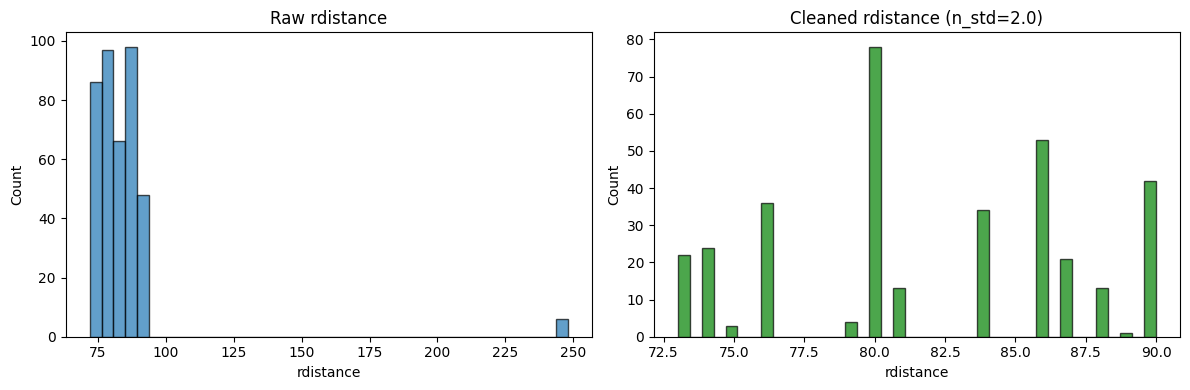

In [6]:
# Histograms: raw and cleaned rdistance
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_histogram_raw(df_reg0, value_col="rdistance", bins=40, ax=axes[0])
plot_histogram_cleaned(df_reg0, value_col="rdistance", n_std=2.0, bins=40, ax=axes[1])
plt.show()

/var/folders/cc/tndmz9tn2p55g6c3x9hx25bc0000gn/T/ipykernel_40326/3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


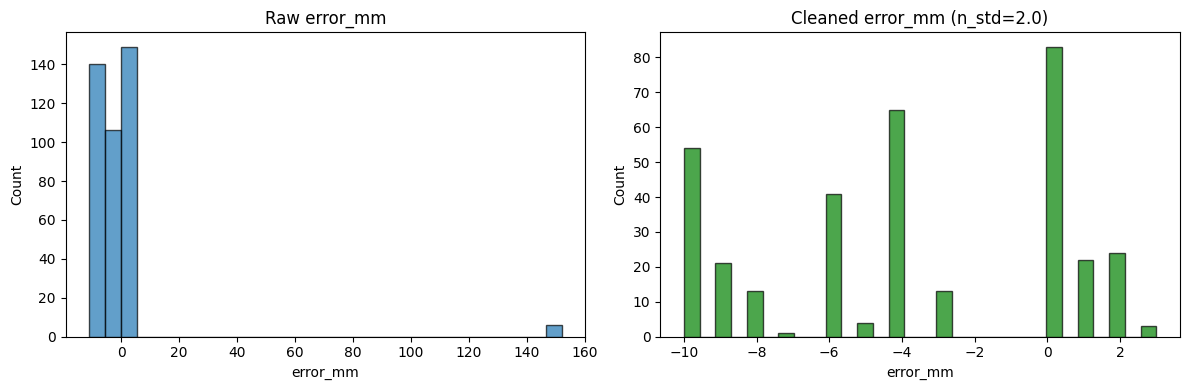

In [7]:
# Histograms: raw and cleaned error
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_histogram_raw(df_reg0, value_col="error_mm", bins=30, ax=axes[0])
plot_histogram_cleaned(df_reg0, value_col="error_mm", n_std=2.0, bins=30, ax=axes[1])
plt.show()

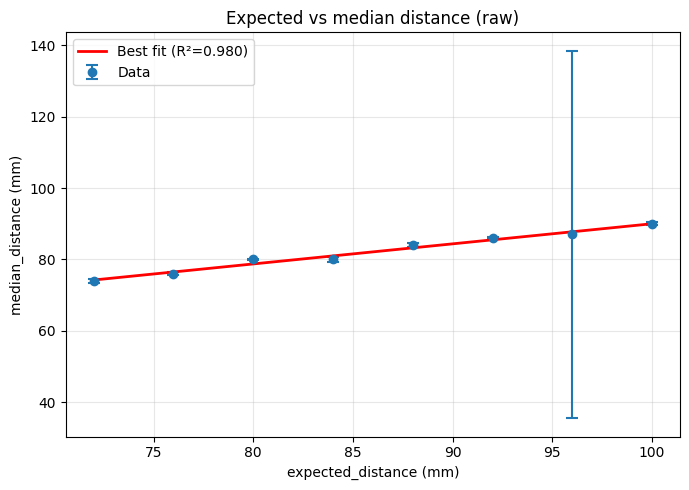

In [8]:
# Expected vs actual from raw stats (no outlier removal)
stats = get_stats(df, register=0)
plot_expected_vs_actual(stats, y_col="median_distance", y_err_col="std_distance", title="Expected vs median distance (raw)")
plt.show()

/var/folders/cc/tndmz9tn2p55g6c3x9hx25bc0000gn/T/ipykernel_40326/3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


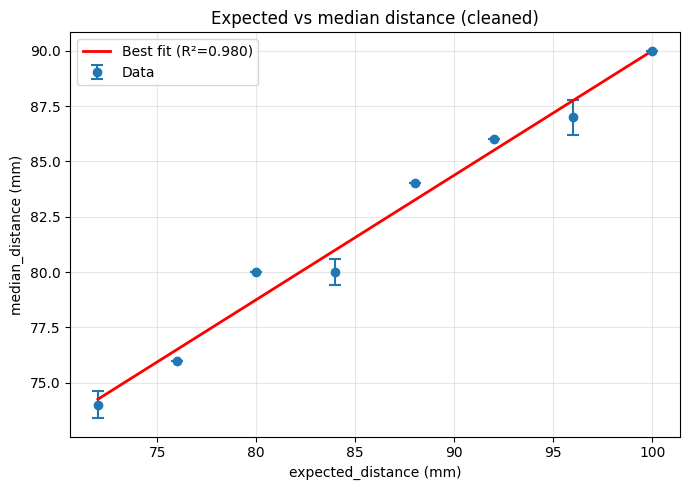

In [9]:
# Expected vs actual from cleaned data (outliers removed per trial)
plot_expected_vs_actual_from_cleaned(df, register=0, n_std=2.0, title="Expected vs median distance (cleaned)")
plt.show()

/var/folders/cc/tndmz9tn2p55g6c3x9hx25bc0000gn/T/ipykernel_40326/3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


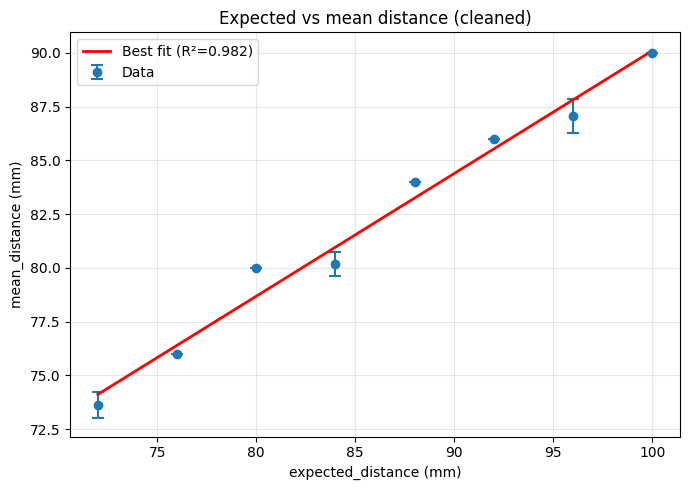

In [10]:
# Same with mean instead of median
plot_expected_vs_actual_from_cleaned(df, register=0, n_std=2.0, use_mean=True, title="Expected vs mean distance (cleaned)")
plt.show()

In [11]:
# Regression stats (slope, intercept, R²) for characterization
stats_raw = get_stats(df, register=0)
stats_cleaned = get_stats(remove_outliers_per_trial(df[df["register"] == 0], n_std=2.0), register=None)
for name, s in [("raw", stats_raw), ("cleaned", stats_cleaned)]:
    r = regression_stats(s)
    if r:
        print(f"{name}: slope={r['slope']:.3f}, intercept={r['intercept']:.3f}, R²={r['r_squared']:.3f}")

raw: slope=0.562, intercept=33.750, R²=0.980
cleaned: slope=0.562, intercept=33.750, R²=0.980


/var/folders/cc/tndmz9tn2p55g6c3x9hx25bc0000gn/T/ipykernel_40326/3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)
